# Energy-based Model (In-progress)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/07_ebm/01_ebm/ebm.ipynb)

In [1]:
import random
import collections
from tqdm.notebook import tqdm

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as Transforms
from torchinfo import summary

from torcheval import metrics as Metrics

from matplotlib import pyplot as plt

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # this is only for Mac metal chips
print(DEVICE)

mps


## 0. Training Parameters

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 5e-3
ALPHA = 0.1
GRADIENT_CLIP = 3e-2
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 1e-4
EPOCHS = 60

## 1. MNIST Dataset

In [3]:
def get_dataloader():

    transform = Transforms.Compose([
                    Transforms.ToTensor(),
                    Transforms.Resize(IMAGE_SIZE, antialias=True),
                    Transforms.Normalize((0.5), (0.5)),])

    train_ds = torchvision.datasets.MNIST("./data", train=True,
                                          download=True,
                                          transform=transform)
    test_ds = torchvision.datasets.MNIST("./data", train=False,
                                          download=True,
                                          transform=transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=4)

    return train_loader, test_loader

In [4]:
# check dataset and dataloader
temp_loader, _ = get_dataloader()
print(next(iter(temp_loader))[0].shape)

torch.Size([128, 1, 32, 32])


In [5]:
test_imgs = next(iter(temp_loader))
test_fig = test_imgs[0][0]
test_fig = test_fig.data.clamp_(min=-1.0, max=1.0)

## 2. Building Energy Function $E(x)$

In [6]:
class Energy(nn.Module):

    conv_layers = 4
    channels:list = [1, 16, 32, 64, 64]
    kernels:list = [5, 3, 3, 3]
    
    def __init__(self):
        super().__init__()
        modules = []
        # Adding convolutional layers + Swish activations
        for i in range(self.conv_layers):
            modules.append(nn.Conv2d(in_channels=self.channels[i], 
                                     out_channels=self.channels[i+1], 
                                     kernel_size=self.kernels[i],
                                     stride=2,
                                     padding=self.kernels[i] // 2))
            modules.append(nn.SiLU())

        # Adding linear layers
        modules += [nn.Flatten(),
                    nn.Linear(in_features=256, out_features=64),
                    nn.SiLU(),
                    nn.Linear(64, 1)]
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

In [7]:
summary(Energy(), input_size=(32, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Energy                                   [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 16, 16, 16]          416
│    └─SiLU: 2-2                         [32, 16, 16, 16]          --
│    └─Conv2d: 2-3                       [32, 32, 8, 8]            4,640
│    └─SiLU: 2-4                         [32, 32, 8, 8]            --
│    └─Conv2d: 2-5                       [32, 64, 4, 4]            18,496
│    └─SiLU: 2-6                         [32, 64, 4, 4]            --
│    └─Conv2d: 2-7                       [32, 64, 2, 2]            36,928
│    └─SiLU: 2-8                         [32, 64, 2, 2]            --
│    └─Flatten: 2-9                      [32, 256]                 --
│    └─Linear: 2-10                      [32, 64]                  16,448
│    └─SiLU: 2-11                        [32, 64]                  --

## 3. Setting Up Langevin Sampler

In [8]:
# Still a lot of uncertainty in this block

def generate_samples(
        model, input_imgs, steps, step_size, return_img_per_step=False):
    
    #turn off the gradient for the model; we only need gradients for the input image
    model_state = model.training
    grad_state = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
    noise = torch.randn(input_imgs.shape, device=input_imgs.device)
    
    model.eval()
    for params in model.parameters():
        params.requires_grad = False
    input_imgs.requires_grad = True
        
    imgs_per_step = []
    for _ in range(steps):
        # step 1: add noise to the input image
        noise.normal_(0, NOISE)
        input_imgs.data.add_(noise.data)
        input_imgs.data.clamp_(min=-1.0, max=1.0)

        # step 2: calculate gradients for the current input
        output_imgs = model(input_imgs)
        output_imgs.sum().backward() # is `sum` really necessary?
        input_imgs.grad.data.clamp_(-GRADIENT_CLIP, GRADIENT_CLIP) # preventing gradient explosion or vanishing

        # apply gradients to the current sample
        input_imgs.data.add_(step_size * input_imgs.grad.data)
        input_imgs.grad.detach_()
        input_imgs.grad.zero_()
        input_imgs.data.clamp_(min=-1.0, max=1.0)

        if return_img_per_step:
            imgs_per_step.append(input_imgs.clone().detach())

    # reset model states
    for params in model.parameters():
        params.requires_grad = True
    
    if model_state: model.train()
    torch.set_grad_enabled(grad_state)

    if return_img_per_step:
        return torch.stack(imgs_per_step, dim=0)
    else:
        return input_imgs

## 4. Setting up Buffer to Store Examples

In [9]:
class Buffer:

    sample_size = BATCH_SIZE
    channels = CHANNELS
    img_size = IMAGE_SIZE
    device = DEVICE
    buffer_size = BUFFER_SIZE
    
    def __init__(self, model):
        self.model = model
        self.examples = [torch.rand(size=(1, self.channels, self.img_size, self.img_size)) * 2 - 1  
                             for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps, step_size):
        
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.randn(size=(n_new, self.channels, self.img_size, self.img_size))
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        input_imgs = torch.cat([old_imgs, rand_imgs], dim=0).detach().to(self.device)

        input_imgs = generate_samples(self.model, input_imgs, steps, step_size)
        self.examples = list(input_imgs.to("cpu").chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.buffer_size]
        
        return input_imgs

## 5. Setting up Energy-Based Model

In [10]:
class EBM:

    alpha = ALPHA
    lr = LEARNING_RATE
    steps = STEPS
    step_size = STEP_SIZE
    noise_scale = NOISE
    device = DEVICE

    def __init__(self, model):
        self.model = model
        self.buffer = Buffer(self.model)
        # optimizer
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # metrics
        self.train_metrics = {
            "loss": Metrics.Mean(),
            "reg_loss": Metrics.Mean(),
            "cdiv_loss": Metrics.Mean(),
            "real": Metrics.Mean(),
            "fake": Metrics.Mean()
        }
        
        self.valid_metrics = {
            "cdiv_loss": Metrics.Mean(),
            "real": Metrics.Mean(),
            "fake": Metrics.Mean()
        }

    
    def train_step(self, real_imgs):
        self.model.train()
        self.clear_metrics()

        real_imgs = real_imgs.to(self.device)
        noise = torch.randn_like(real_imgs) * self.noise_scale
        real_imgs.add_(noise).clamp_(min=-1.0, max=1.0)
        fake_imgs = self.buffer.sample_new_exmps(self.steps, self.step_size)
        input_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        self.optim.zero_grad()
        real_out, fake_out = self.model(input_imgs).chunk(2, dim=0)

        reg_loss = self.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        self.optim.step()

        # update parameters
        self.train_metrics["loss"].update(loss.detach().cpu())
        self.train_metrics["reg_loss"].update(reg_loss.detach().cpu())
        self.train_metrics["cdiv_loss"].update(cdiv_loss.detach().cpu())
        self.train_metrics["real"].update(real_out.mean().detach().cpu())
        self.train_metrics["fake"].update(fake_out.mean().detach().cpu())
        
        return loss

    
    @torch.no_grad()
    def validation_step(self, real_imgs):
        self.model.eval()
        
        real_imgs = real_imgs.to(self.device)
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        input_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.model(input_imgs).chunk(2, dim=0)

        cdiv_loss = fake_out.mean() - real_out.mean()

        self.valid_metrics["cdiv_loss"].update(cdiv_loss.detach().cpu())
        self.valid_metrics["real"].update(real_out.mean().detach().cpu())
        self.valid_metrics["fake"].update(fake_out.mean().detach().cpu())


    def clear_metrics(self):
        for metric in self.train_metrics.values():
            metric.reset()
        for metric in self.valid_metrics.values():
            metric.reset()

## 6. Train EBM

In [11]:
train_loader, test_loader = get_dataloader()
model = Energy().to(DEVICE)
ebm = EBM(model)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch:  0


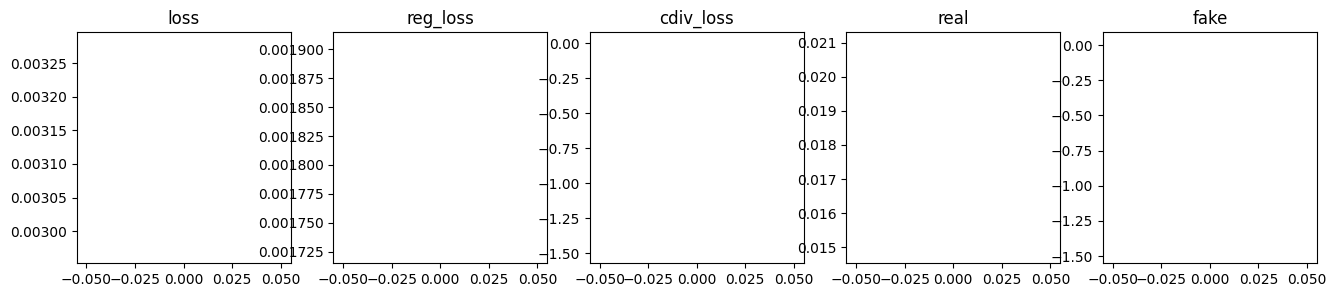

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch:  1


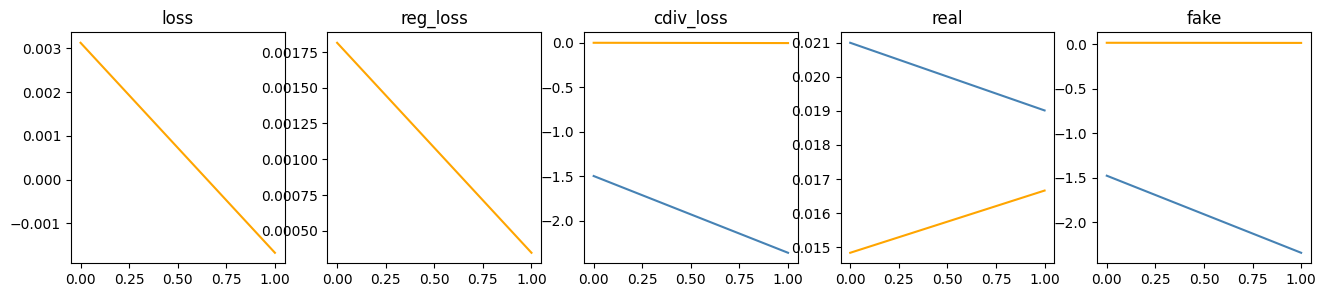

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch:  2


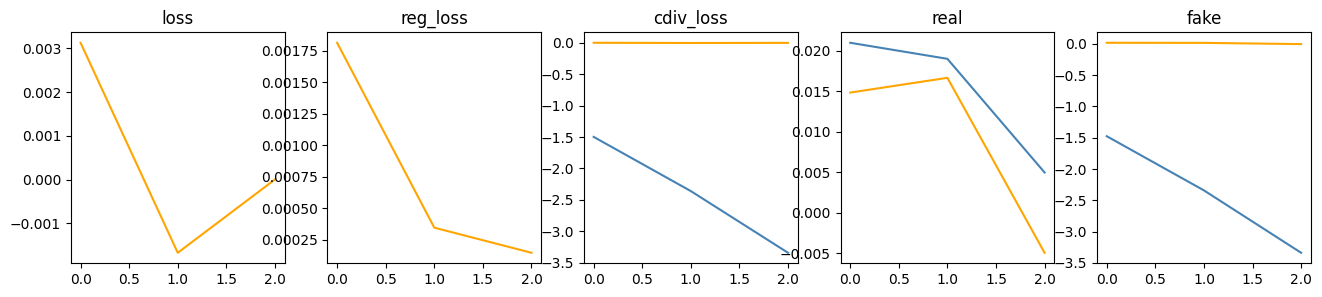

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:

train_history = collections.defaultdict(list)
valid_history = collections.defaultdict(list)

for epoch in range(EPOCHS):

    for _, (input_imgs, label) in enumerate(tqdm(train_loader)):
        ebm.train_step(input_imgs)


    for key, item in ebm.train_metrics.items():
        val = item.compute().item()
        train_history[key].append(val)
        # print(key, " | ", f"{val:.6f}")
        
    for _, (input_imgs, label) in enumerate(tqdm(test_loader)):
        ebm.validation_step(input_imgs)
    

    for key, item in ebm.valid_metrics.items():
        val = item.compute().item()
        valid_history[key].append(val)
        # print(key, " | ", f"{val:.6f}")
    
    print("Epoch: ", epoch + 1ii)
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(train_history):
        ax = plt.subplot(1, len(train_history), i + 1)
        ax.plot(train_history[key], c="orange")
        if key in valid_history:
            ax.plot(valid_history[key], c="steelblue")
        ax.set_title(key)
    plt.show()
        



loss  |  -0.013808
reg_loss  |  0.003626
cdiv_loss  |  0.003626
real  |  0.058417
fake  |  0.040983
